In [ ]:
import pandas as pd
import sqlite3

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dfTransjakarta_clean.xlsx to dfTransjakarta_clean.xlsx


In [ ]:
df = pd.read_excel("dfTransjakarta_clean.xlsx")
df.head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,...,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount_clean,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,10,P00142,...,7,2023-04-03 05:21:44,P00253,Tegalan,-6203101,10685715,120,2023-04-03 06:00:53,3500,35000
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0,B01963P,...,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6217152,10681892,210,2023-04-03 06:40:01,3500,35000
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0,B00499P,...,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6133731,10681475,390,2023-04-03 06:50:55,3500,35000
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0,B05587P,...,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6183068,10693194,290,2023-04-03 06:28:16,3500,35000
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0,P00239,...,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6135355,10681143,150,2023-04-03 06:57:03,3500,35000


In [ ]:
conn = sqlite3.connect("transjakarta.db")
df.to_sql("transjakarta_trips", conn, if_exists="replace", index=False)
pd.read_sql("SELECT COUNT(*) as total_rows FROM transjakarta_trips", conn)

,total_rows
0,35588


In [ ]:
import matplotlib.pyplot as plt

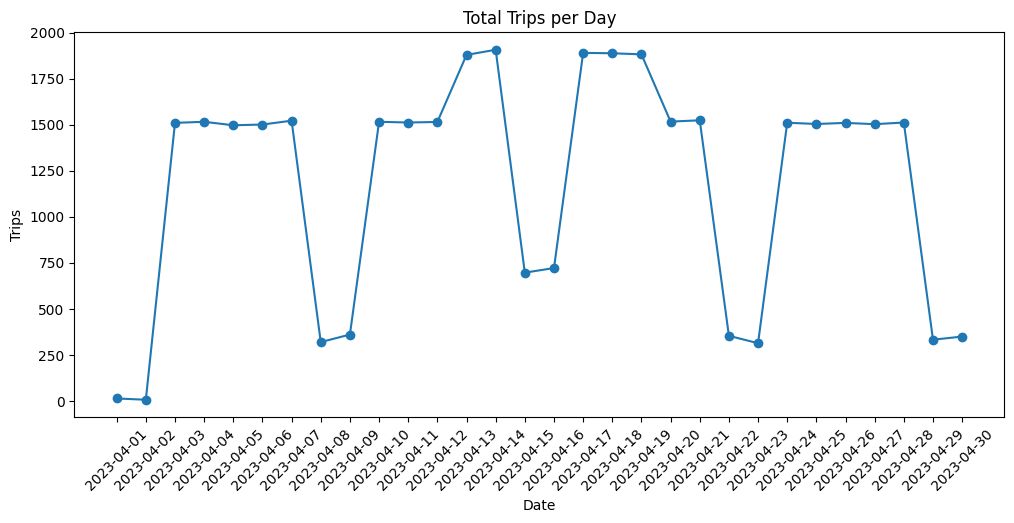

In [ ]:
query = """
SELECT DATE(tapInTime) as trip_date, COUNT(*) as total_trips
FROM transjakarta_trips
GROUP BY DATE(tapInTime)
ORDER BY trip_date;
"""
df_trend = pd.read_sql(query, conn)

plt.figure(figsize=(12,5))
plt.plot(df_trend["trip_date"], df_trend["total_trips"], marker='o')
plt.xticks(rotation=45)
plt.title("Total Trips per Day")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.show()

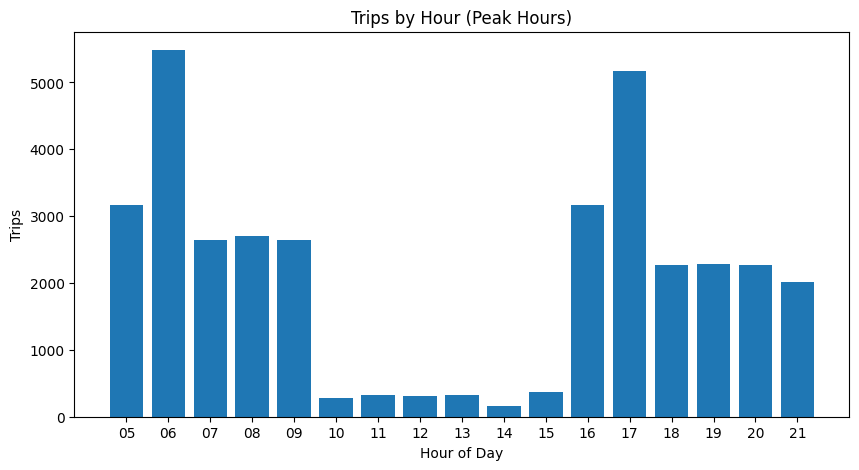

In [ ]:
query = """
SELECT strftime('%H', tapInTime) as hour, COUNT(*) as total_trips
FROM transjakarta_trips
GROUP BY hour
ORDER BY hour;
"""
df_hour = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
plt.bar(df_hour["hour"], df_hour["total_trips"])
plt.title("Trips by Hour (Peak Hours)")
plt.xlabel("Hour of Day")
plt.ylabel("Trips")
plt.show()

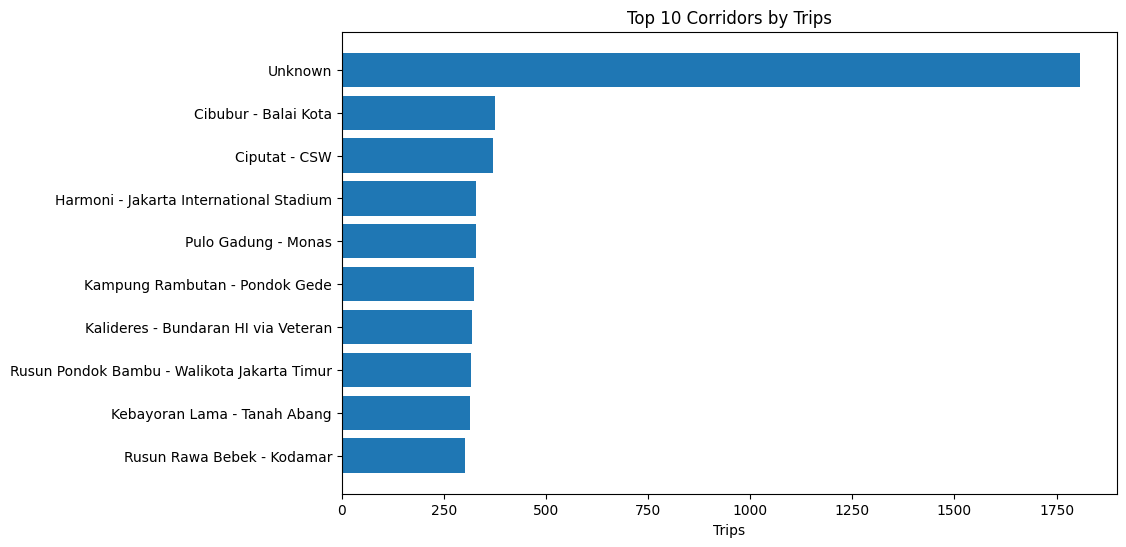

In [ ]:
query = """
SELECT corridorName, COUNT(*) as total_trips
FROM transjakarta_trips
GROUP BY corridorName
ORDER BY total_trips DESC
LIMIT 10;
"""
df_corridor = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
plt.barh(df_corridor["corridorName"], df_corridor["total_trips"])
plt.title("Top 10 Corridors by Trips")
plt.xlabel("Trips")
plt.gca().invert_yaxis()
plt.show()

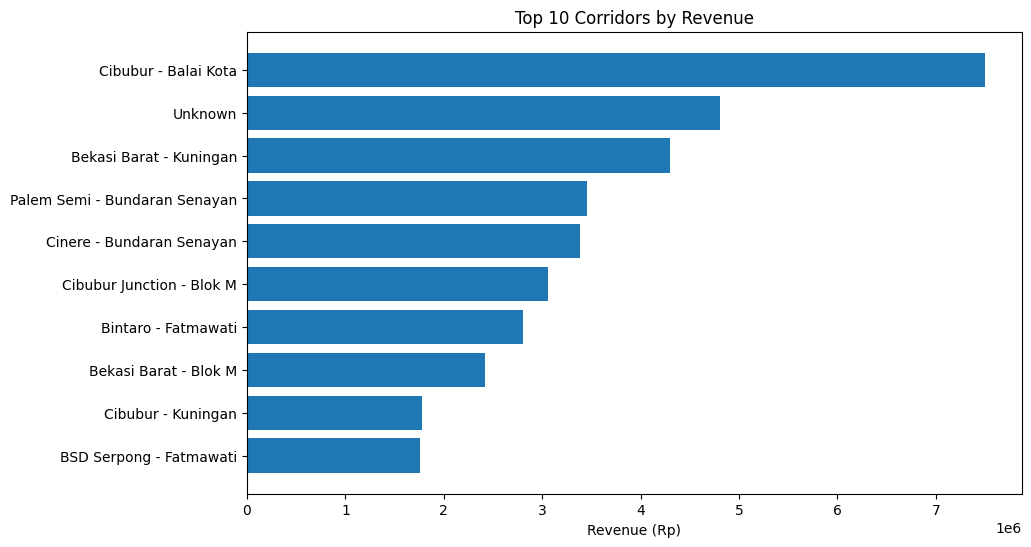

In [ ]:
query = """
SELECT corridorName, SUM(payAmount_clean) as total_revenue
FROM transjakarta_trips
GROUP BY corridorName
ORDER BY total_revenue DESC
LIMIT 10;
"""
df_revenue = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
plt.barh(df_revenue["corridorName"], df_revenue["total_revenue"])
plt.title("Top 10 Corridors by Revenue")
plt.xlabel("Revenue (Rp)")
plt.gca().invert_yaxis()
plt.show()

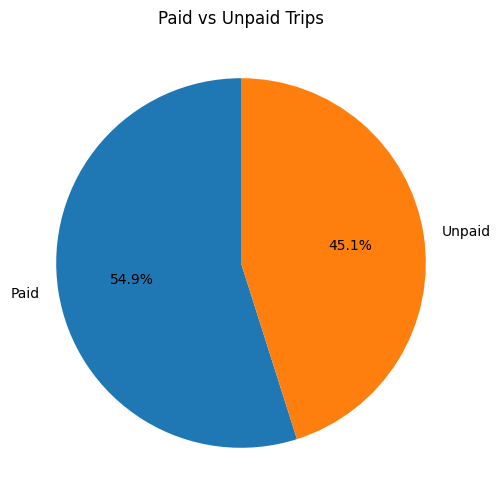

In [ ]:
query = """
SELECT CASE
           WHEN payAmount_clean = 0 THEN 'Unpaid'
           ELSE 'Paid'
       END as payment_status,
       COUNT(*) as total_trips
FROM transjakarta_trips
GROUP BY payment_status;
"""
df_paid = pd.read_sql(query, conn)

plt.figure(figsize=(6,6))
plt.pie(df_paid["total_trips"], labels=df_paid["payment_status"], autopct='%1.1f%%', startangle=90)
plt.title("Paid vs Unpaid Trips")
plt.show()

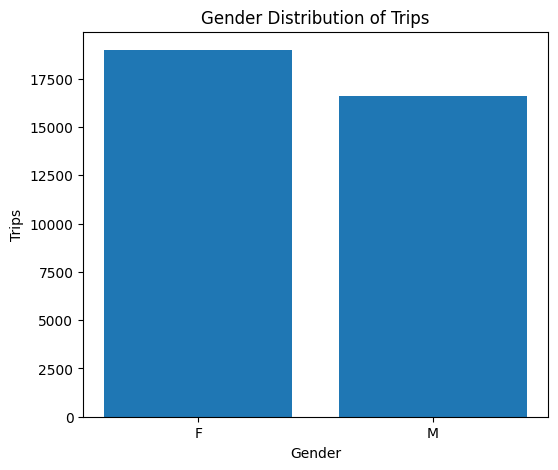

In [ ]:
query = """
SELECT payCardSex, COUNT(*) as total_trips
FROM transjakarta_trips
GROUP BY payCardSex;
"""
df_gender = pd.read_sql(query, conn)

plt.figure(figsize=(6,5))
plt.bar(df_gender["payCardSex"], df_gender["total_trips"])
plt.title("Gender Distribution of Trips")
plt.xlabel("Gender")
plt.ylabel("Trips")
plt.show()

In [ ]:
query = """
SELECT AVG(julianday(tapOutTime) - julianday(tapInTime)) * 24 * 60 as avg_duration_minutes
FROM transjakarta_trips
WHERE tapOutTime IS NOT NULL;
"""
df_duration = pd.read_sql(query, conn)
print("Rata-rata durasi perjalanan (menit):", round(df_duration.iloc[0,0], 2))

Rata-rata durasi perjalanan (menit): 72.09


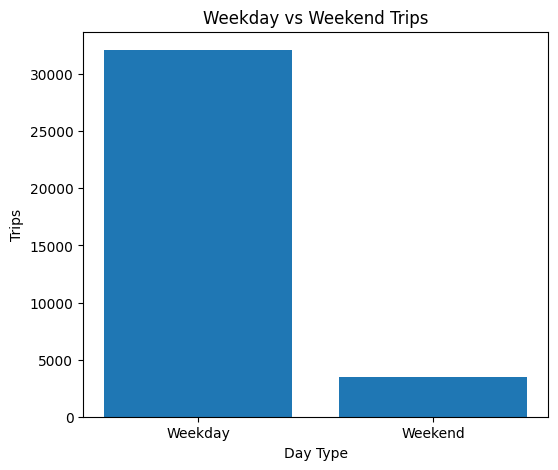

In [ ]:
query = """
SELECT CASE
           WHEN strftime('%w', tapInTime) IN ('0','6') THEN 'Weekend'
           ELSE 'Weekday'
       END as day_type,
       COUNT(*) as total_trips
FROM transjakarta_trips
GROUP BY day_type;
"""
df_daytype = pd.read_sql(query, conn)

plt.figure(figsize=(6,5))
plt.bar(df_daytype["day_type"], df_daytype["total_trips"])
plt.title("Weekday vs Weekend Trips")
plt.xlabel("Day Type")
plt.ylabel("Trips")
plt.show()

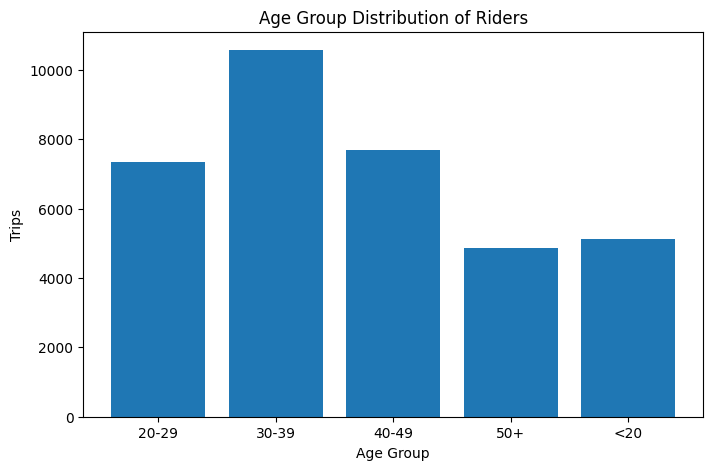

In [ ]:
query = """
SELECT
    CASE
        WHEN (strftime('%Y','now') - payCardBirthDate) < 20 THEN '<20'
        WHEN (strftime('%Y','now') - payCardBirthDate) BETWEEN 20 AND 29 THEN '20-29'
        WHEN (strftime('%Y','now') - payCardBirthDate) BETWEEN 30 AND 39 THEN '30-39'
        WHEN (strftime('%Y','now') - payCardBirthDate) BETWEEN 40 AND 49 THEN '40-49'
        ELSE '50+'
    END as age_group,
    COUNT(*) as total_trips
FROM transjakarta_trips
GROUP BY age_group
ORDER BY age_group;
"""
df_age = pd.read_sql(query, conn)

plt.figure(figsize=(8,5))
plt.bar(df_age["age_group"], df_age["total_trips"])
plt.title("Age Group Distribution of Riders")
plt.xlabel("Age Group")
plt.ylabel("Trips")
plt.show()

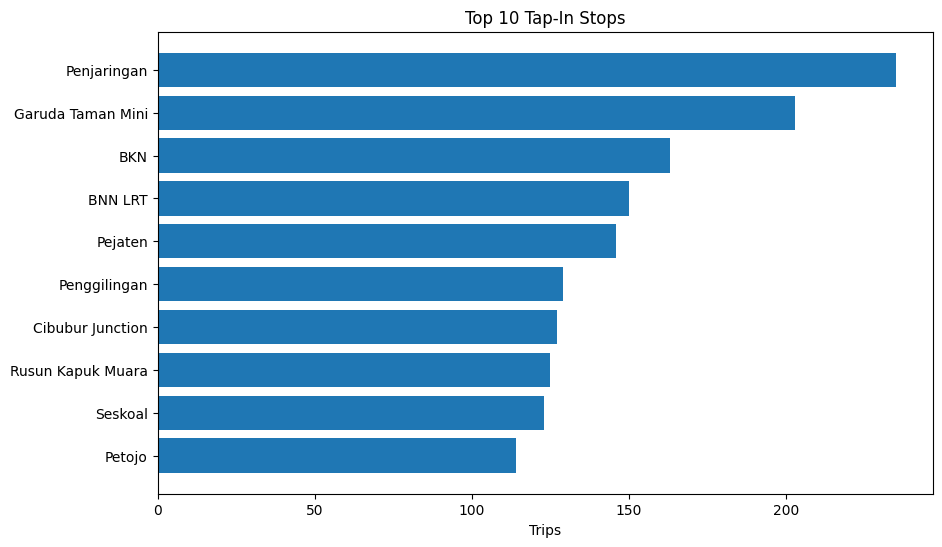

In [ ]:
query = """
SELECT tapInStopsName, COUNT(*) as total_trips
FROM transjakarta_trips
GROUP BY tapInStopsName
ORDER BY total_trips DESC
LIMIT 10;
"""
df_tapin = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
plt.barh(df_tapin["tapInStopsName"], df_tapin["total_trips"])
plt.title("Top 10 Tap-In Stops")
plt.xlabel("Trips")
plt.gca().invert_yaxis()
plt.show()